<a href="https://colab.research.google.com/github/haneenna1/Machine-learnign-and-human-behaviour/blob/main/Copy_of_HW2_2022_students_d71f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1>236606 - Machine Learning and Human Behavior</h1>
<h2>Homework #2 - Discrete Choice ✨</h2>
</center>

## Submission guidelines: 
1. Submit a .ipynb file with your solution for tasks 1 and 2. 
2. Add a text block in the beginning of your notebook with your IDs. 
3. Indicate clearly with a text block the sections of your solutions .
4. For any questions regarding this homework, contact Bar: beini@campus.technion.ac.il.


## Preliminaries
Run these cells to load into memory objects and functions that will be used throughtout today's workshop.

In [1]:
#@title Import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import abc
import string
import statsmodels.api as sm
import itertools
from sklearn import svm, linear_model
import pandas as pd
import sys
import pickle as pkl

from collections import OrderedDict

%config InlineBackend.figure_format = 'retina'

In [2]:
#@title Context Effect
# user model types

# Generate Choice 

class UserModel(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, X, *args):
    '''
    Given items X, calculate the user's valuation v(x) for each item x
    '''
    raise NotImplementedError()
  
  def predict(self, X, *args):
    raise NotImplementedError()


class RationalUserModel(UserModel):

  def __init__(self, num_features, beta_h):
    self.num_features = num_features
    self.beta_h = beta_h
    self.type = "rational"

  def __call__(self, X):
    return X@self.beta_h
  
  def choice(self, X):
    return np.argmax(self(X), axis=0)


class AttractionUserModel(UserModel):
  def __init__(self, beta_h, alpha_attr):
    # rational_utility_weights
    self.rational_utility_weights = beta_h 
    # attraction_coefficient
    self.attraction_coefficient = alpha_attr
    self.name = "attraction"

  def __call__(self, X):
    # X: shape=(num_items,num_features) - Item covariates
    return (
        self._rational_decision_term(X)
        + self.attraction_coefficient*self._attraction_term(X)
    )

  def _rational_decision_term(self, X):
    return X@self.rational_utility_weights

  def _attraction_term(self, X):
    # Calculate preference vector
    preference_vector = X.max(axis=0)-X.min(axis=0)
    preference_vector_normalized = (
        preference_vector
        /np.sqrt(preference_vector@preference_vector)
    )
    # Calculate dominance and distance matrices
    N = len(X)
    dominance = np.zeros((N,N))
    distance = np.zeros((N,N))
    for i in range(N):
      for j in range(N):
        dominance[i,j] = (+1)*np.all(X[i]-X[j] >= 0) + (-1)*np.all(X[j]-X[i] >= 0)
        distance[i,j] = abs(preference_vector_normalized@(X[i]-X[j]))

    attraction_terms = (dominance*distance).sum(axis=1)
    return attraction_terms
  
  def choice(self, X):
    return np.argmax(self(X), axis=0)

In [3]:
#@title Context Effects Environment


class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 8
    observations_per_user = 10
    items_per_slate = 1
    train_user_proportion = 0.6

    def _generate_user_item_attributes(self, n_users):
        """
        Generate latent parameters for users and items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, items_per_slate, n_features)
        """
        users = np.random.normal(
            size=(
                n_users,
                self.n_features,
            ),
        )
        items = np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.items_per_slate,
                self.n_features,
            ),
        )
        return users, items

    def _choice(self, users, items):
        """
        Discrete choice function
        
        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, items_per_slate, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError
    
    def _generate_choice_dataset(self, n_users):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users, items = self._generate_user_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = f'{i}'
                dct['slate_id'] = f'{i}_{j}'
                for k in range(self.items_per_slate):
                    for l in range(self.n_features):
                        dct[f'x_{k},{l}'] = items[i,j,k,l]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df
    
    def generate_datasets(self, n_users):
        n_train_users = int(n_users*self.train_user_proportion)
        n_test_users = n_users - n_train_users
        return (
            self._generate_choice_dataset(n_train_users),
            self._generate_choice_dataset(n_test_users),
        )


class ContextChoiceEnvironment(DiscreteChoiceEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def __init__(self,
                 slate_number=1,
                 observations_per_user=50,
                 num_items_omega=15):
      
        # self.noise_scale = noise_scale
        self.user_model = AttractionUserModel(
                          beta_h=np.array([1,9]),
                          alpha_attr=3,
                          )
        self.slate_number = slate_number
        self.observations_per_user = observations_per_user
        self._generate_ex1_items(slate_number=slate_number,
                                 num_items_omega=num_items_omega)


    def _generate_ex1_items(self, slate_number=1, num_items_omega=15):
      if slate_number == 1:
        self.omega = np.array([[1,3,3,4,10,4,2],[1,7.5,5,4,5,6,1]]) 
        self.E_s = np.array([10, 80, 30, 40, 20, 30, 100])
        self.omega_tag = np.array([[4,2.5,4.5],[4.5,6,5]])
        self.E_s_tag = np.array([5, 8, 3])

      elif slate_number == 2:
        self.omega = np.array([[3,8,8.5,4,10,8,2, 1],[8,7,4,4,5,6,1, 8]])
        self.E_s = np.array([10, 90, 30, 50, 30, 40,100,90])

        self.omega_tag = np.array([[4,3,4.5,6],[8,6,5,6]])
        self.E_s_tag = np.array([5, 8, 3, 9])

      else:
        np.random.seed(42) 
        num_items_omega = 15
        self.omega, self.omega_tag = list(), list()
        self.E_s, self.E_s_tag = list(), list()

        for i in range(self.observations_per_user):
          self.omega.append(np.hstack([np.zeros((num_items_omega, 1)),
                                        np.ones((num_items_omega, 1))*i,
                                        np.random.randint(
                                            20,size=(num_items_omega,2)),
                                       np.random.randint(
                                           20,100,size=(num_items_omega,1))
                                        ]
                                       )
          )
          
          self.omega_tag.append(np.hstack([np.zeros((100, 1)),
                              np.ones((100, 1))*i,
                              np.random.randint(
                                  20,size=(100,2)),
                              np.random.randint(20,size=(100,1))
                              ]
                              )
          )

        self.omega = np.vstack(self.omega).T
        self.omega_tag = np.vstack(self.omega_tag).T
      return

    def _items_to_frame(self, omega, E_s, char_start=ord('A')):

        data = pd.DataFrame(omega.T).reset_index()
        if len(data) < self.observations_per_user:
          data['user_id'] = np.zeros(len(data))
          data['slate_id'] = np.zeros(len(data))
          data['rantional_user_val'] = omega.T@\
                            self.user_model.rational_utility_weights
          data["E_s"] = E_s

        else:
          data['rantional_user_val'] = data.loc[:,[2,3]].values@\
                  self.user_model.rational_utility_weights

          data.rename(columns={0:'user_id', 1:'slate_id',
                               2:'x_0', 3:'x_1', 4:'E_s'},
                      inplace=True)

        data['name'] = data['index'].apply(lambda x: chr(char_start+x))

        return data


    def inspect_data(self, items_type="current", slate_id=-1):
      
      if items_type == "current":
        data =  self._items_to_frame(self.omega,self.E_s)
      elif items_type == "tag":
        data =  self._items_to_frame(self.omega_tag, self.E_s_tag, ord('A') + len(self.E_s)+1) #todo: change this

      return data      


    def generate_datasets(self):
      
      print('here1')
      data = pd.DataFrame(self.omega.T).reset_index()
      print('len(data) = ', len(data))
      print('observations_per_user = ', self.observations_per_user)
      if len(data) < self.observations_per_user:
        print('here2')

        data['user_id'] = np.zeros(len(data))
        data['slate_id'] = np.zeros(len(data))
        data['name'] = data['index'].apply(lambda x: chr(ord('A')+x))
        data['rantional_user_val'] = self.omega.T@\
                                    self.user_model.rational_utility_weights
        self.top_5 = data.rantional_user_val.argsort()[-5:][::-1]
        data['top_5'] = data['index'].apply(lambda x: x in self.top_5.values)
        data['perceived_val'] = np.nan
        data.loc[self.top_5, ['perceived_val']] = self.user_model(data.loc[self.top_5, [0,1]].values)
        data = self._choice(data)
      print('here3')
      return data

      
    def _choice(self, data):
        dummies = pd.get_dummies(data['index'])
        # for name, group in grouped:
        self.chosen = data['perceived_val'].idxmax()
        data['chosen'] = dummies.iloc[data['perceived_val'].idxmax(), :]
        return data

    def add_item(self, index):
      self.omega = np.hstack([self.omega,self.omega_tag[:,index].reshape(2,1)])
      self.E_s =np.hstack([self.E_s,self.E_s_tag[1]])
      return

    def pop_item(self):
      self.omega = self.omega[:,:-1]
      self.E_s =self.E_s[:-1]
      return
    
    def top_5(self, rantional_user_val):
      return rantional_user_val.argsort()[-5:][::-1]

    def plot_omega(self):
      area = 20

      self.generate_datasets()
      fig, ax = plt.subplots()
      ax.scatter(self.omega[0,:], self.omega[1,:], s=80,label="$\Omega$")
      plt.title('Items in $\Omega$', fontsize=20)
      plt.xlabel('$X_1$')
      plt.ylabel('$X_2$')
      plt.grid()
      # # color the top three items
      ax.scatter(self.omega[0,self.top_5], self.omega[1,self.top_5], s=80, color='red')
      # add annotations
      S_len = self.omega.shape[1]
      for i, txt in enumerate(string.ascii_uppercase[:S_len]):
          ax.annotate(txt, (self.omega[0,:][i]+0.05, self.omega[1,:][i]+0.07))
      ax.scatter(self.omega[0,self.chosen], self.omega[1,self.chosen], s=80, color='red',edgecolors='black',linewidths=2)
      
      plt.show()

    def plot_two_sets(self):
      area = 20

      fig, ax = plt.subplots()
      ax.scatter(self.omega[0,:], self.omega[1,:], s=80,label="$\Omega$")
      plt.title('Items in both sets', fontsize=20)
      plt.xlabel('$X_1$')
      plt.ylabel('$X_2$')
      plt.grid()
      # inspect set of decoyes 
      ax.scatter(self.omega_tag[0,:],self.omega_tag[1,:], s=80, label="$\Omega'$")
      plt.legend(loc='lower right')


      # add annotations and print user values
      S_len = self.omega.shape[1]
      Sw_s = S_len + 1
      Sw_len = Sw_s + self.omega_tag.shape[1]
      for i, txt in enumerate(string.ascii_uppercase[:S_len]):
          ax.annotate(txt, (self.omega[0,:][i]+0.05, self.omega[1,:][i]+0.07))

      for i, txt in enumerate(string.ascii_uppercase[Sw_s:Sw_len]):
          ax.annotate(txt, (self.omega_tag[0,:][i]+0.1, self.omega_tag[1,:][i]+0.1))
      plt.show()

      return




-----------------
-----------------

## Task 1: engineering choice sets

In this task, you will play "evil designer" and construct sets of available items that cause (non-rational) users to choose items that are bad for them (i.e., have suboptimal value), but good for the system. In particular, users in this task will be susceptible to the *Attracttion* context effect, and the way you construct the set of items should make use of this knowledge.

----------------------------------------

**Recommendation procedure:**
1. The collection of available items is the *ground set* $\Omega=\{x_1,...,x_n\}$ ($n$ may be different in different parts of this task). Each item $x \in s$ is described by two features, $x=(x_1, x_2)$.
2. There is a single user whose (true) value function is $v(x)=\alpha^\top x$. I.e., if the user chooses item $x_i$, then she receives $\alpha_1\cdot x_{i1} + \alpha_2\cdot x_{i2}$ utility from this choice. **The value vector $\alpha$ is known to the system**.
3. System also benefits from user choices. If the user chooses item $x_i$, then the system receives $e_i$ utility. The values $e_i$ are predetermined, known to the system, and do not depend on features.
4. The system recommends to the user the top-5 items $x\in \Omega$ having highest value. We will call this the *choice set*, denoted $s \in \Omega$.
5. The user chooses exactly one item $x \in s$. This is the item with highest *perceived value*, as determined by the attraction effect:
$$
  \tilde{v}(x|s) = \alpha^\top x + \mathtt{att}(x|s)
$$
where $\mathtt{att}$ is as was defined in class. We will denote the chosen item by $y = \mathtt{argmax}_{x \in s} \tilde{v}(x|s)$.
6. User receives utility $v(y)$, and system receives utility $e_y$.

----------------------------------------

In the above description, the system recommends in a way that is optimal to users. In this task, *you are an agent of the system*, and your goal is to maximize the system's utility.

Of course, you cannot simply force the user to choose a certain item, nor can you change the recommendation procedure. The only thing you are allowed to do is to modify $\Omega$ by adding one additional item from a different set of items, $\Omega'$. Once $\Omega$ is modified (i.e., includes one additional item), the recommendation procedure and user choice behavior is as described above.
Hence, your goal is to (manually) choose $x \in \Omega$ such that the choice $y$ derived from a top-5 recommended set $s$ based on the collection of items $\Omega \cup \{x\}$ will results in high system utility $e_y$ (and possibly with lower utility $v(y)$ to the user).

As you will see, items in  $\Omega'$ actually have lower system values $e_i$ than items in $\Omega$ ($\forall e \in E_S, e' \in E_S':  e > e'$). Therefore, the item you add will serve as a *decoy*: these serve to modify the preceived values of items in $s$, in a way that utilizes the attraction effect to affect choice behavior. 

### 1.1 Guided example - a gentle start:

Set $\Omega$ consists of 7 items:

\begin{align}
{A:(1,1), B:(3,7.5), C:(3,5), D:(4,4), E:(10,5), F:(4,6), G:(2,1)}
\end{align}

with the following system utility values $e_s=\{e_1,\dots,e_n\}$:
\begin{align}
\{10, 20, 80, 40, 20, 80, 100\}
\end{align}

Additionally, we have set $\Omega'$:
\begin{align}
{I:(4,4.5), J:(2.5,6), K:(4.5,5)}
\end{align}
with the following values $e_{s'}$:
\begin{align}
\{5, 8, 3\}
\end{align}

The parameter $\alpha$ of the user value function is: 
\begin{align}
\alpha_1 = 1, \alpha_2 = 9
\end{align}


1.1.1 First, let's see what happens before you intervene. Run the code below to see what 5 items are recommended by the system when $\Omega$ is the ground set,
and what item the user chooses. Make sure you understand what the code does.

In [30]:
attraction_env = ContextChoiceEnvironment()
attraction_env.inspect_data(items_type="current")

,index,0,1,user_id,slate_id,rantional_user_val,E_s,name
0,0,1.0,1.0,0.0,0.0,10.0,10,A
1,1,3.0,7.5,0.0,0.0,70.5,80,B
2,2,3.0,5.0,0.0,0.0,48.0,30,C
3,3,4.0,4.0,0.0,0.0,40.0,40,D
4,4,10.0,5.0,0.0,0.0,55.0,20,E
5,5,4.0,6.0,0.0,0.0,58.0,30,F
6,6,2.0,1.0,0.0,0.0,11.0,100,G


In [31]:
attraction_env.inspect_data(items_type="tag")

,index,0,1,user_id,slate_id,rantional_user_val,E_s,name
0,0,4.0,4.5,0.0,0.0,44.5,5,I
1,1,2.5,6.0,0.0,0.0,56.5,8,J
2,2,4.5,5.0,0.0,0.0,49.5,3,K


1.1.2 Use ```generate_datasets``` method to print a table showing for each of Omega's items (rows) the true value and perceived value for the user (columns). save results to variable ```df```and print

In [33]:
df = attraction_env.generate_datasets()
df
print(type(df))

here1
len(data) =  7
observations_per_user =  50
here2
here3
<class 'pandas.core.frame.DataFrame'>


1.1.3 Use 
```plot_omega``` method to plot all items in 2D space and highlights the top-5 items and the user's choice:

here1
len(data) =  7
observations_per_user =  50
here2
here3


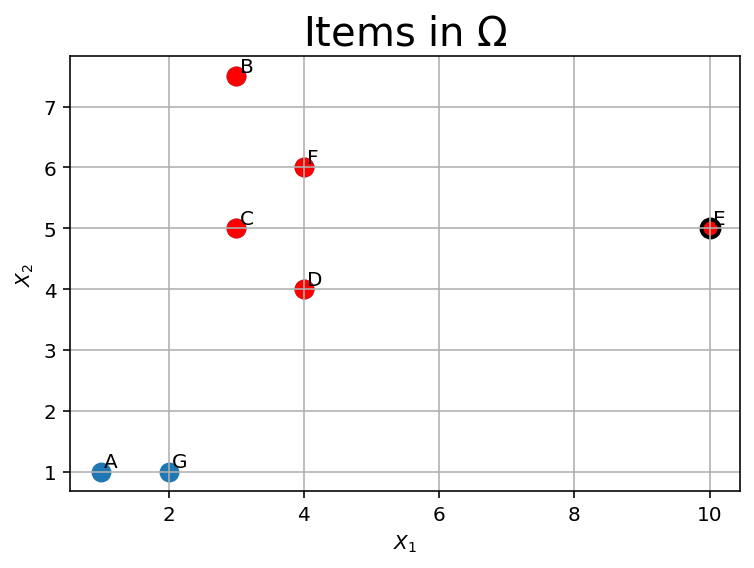

In [7]:
attraction_env.plot_omega()

In the above plot, items in $\Omega$ are dots. Top-5 items that are currently selected from $\omega$ are colored red, and all others are blue. The chosen item has a black border.

Some things to note:
* Items C and D are dominated by E and F (make sure you understand what this means, and why it holds).
* User chooses item E, meaning it has the highest perceived value. However, item E also does not have the highest true value, and so the user is happy.
* The value to the system form the user choosing item E is $e_E=20$.

1.1.4 
What can you do to improve the system's utility?
The next block of code plots items in both $\Omega$ and $\Omega'$ in 2D space:

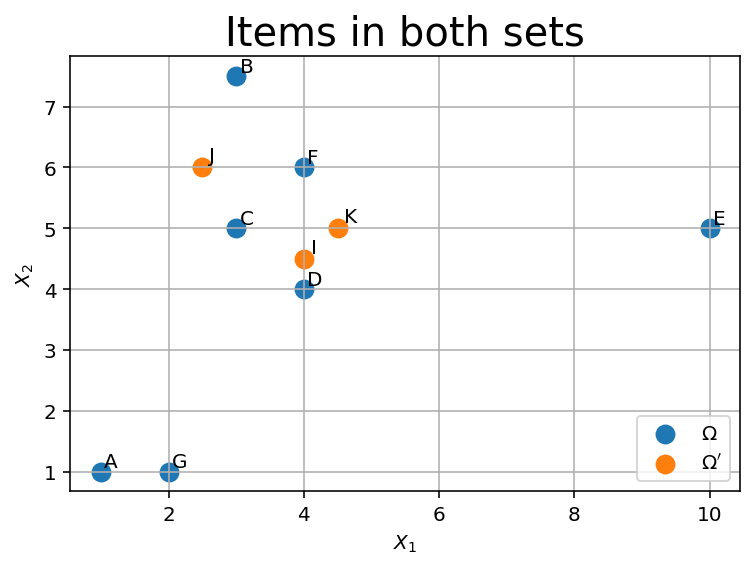

In [8]:
attraction_env.plot_two_sets()

Examine the plot. Using your knowledge about how the attraction effect works, think: if you are allowed to add one item from $\Omega'$ to $\Omega$, and if you are interested in maximizing system utility - which item would you add?

Write your answer, and provide an explanation for your choice.

In [9]:
"""Answer:
The item we would add is
        The item named J=(2.5, 6)
"""

"""The reason is:
First observation: all points in Omega_tag eliminate D from the top-5 element values choice and replace it in this set.
Second observation: Our selection so far is point E.
        1. Item I is dominated by E whereas only so it will enlarge his attrcation and hinder the rest of the items' attraction, making our choice to remain E (sub-optimal for the system's utility)
        2. Item K gives attraction 0 for all points, making our choice to remain E (sub-optimal for the system's utility)
        3. Finally, J benefits the attraction of point B (and benefits noithing to point E) just enough so that now point B is chosen over E. 
        
    B's system utility is 80 ! much better than the system utility of 20 we got from point E.
"""


"The reason is:\nFirst observation: all points in Omega_tag eliminate D from the top-5 element values choice and replace it in this set.\nSecond observation: Our selection so far is point E.\n        1. Item I is dominated by E whereas only so it will enlarge his attrcation and hinder the rest of the items' attraction, making our choice to remain E (sub-optimal for the system's utility)\n        2. Item K gives attraction 0 for all points, making our choice to remain E (sub-optimal for the system's utility)\n        3. Finally, J benefits the attraction of point B (and benefits noithing to point E) just enough so that now point B is chosen over E. \n        \n    B's system utility is 80 ! much better than the system utility of 20 we got from point E.\n"

1.1.5 Next, let's examine what happens when we add $H$ to $\Omega$:

here1
len(data) =  8
observations_per_user =  50
here2
here3


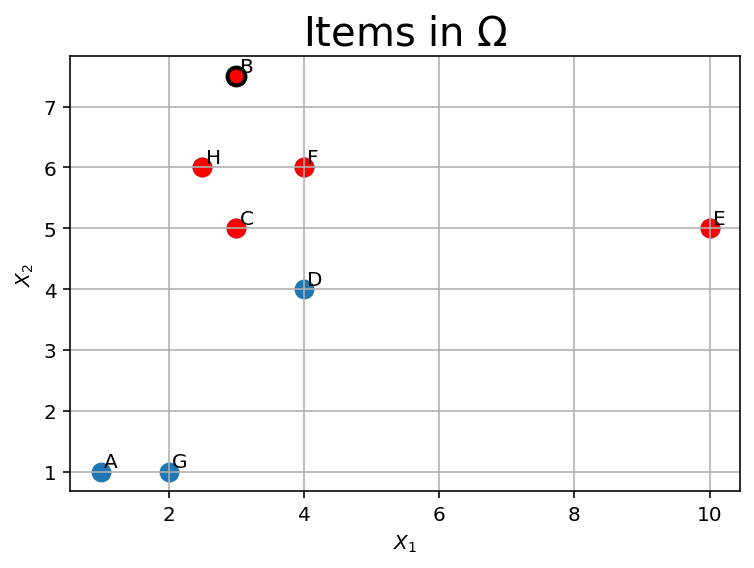

In [10]:
# plot over scatter
# Add new item to S
index = 1 #this is the index of H in Omega'
attraction_env.add_item(index=index)

attraction_env.plot_omega()

Print a table of true value, perceived value, and system utility for all top-5 items:

In [11]:
df_new = attraction_env.generate_datasets()
df_new.loc[df_new['top_5']]

here1
len(data) =  8
observations_per_user =  50
here2
here3


,index,0,1,user_id,slate_id,name,rantional_user_val,top_5,perceived_val,chosen
1,1,3.0,7.5,0.0,0.0,B,70.5,True,75.717758,1
2,2,3.0,5.0,0.0,0.0,C,48.0,True,21.911209,0
4,4,10.0,5.0,0.0,0.0,E,55.0,True,74.922349,0
5,5,4.0,6.0,0.0,0.0,F,58.0,True,66.063808,0
7,7,2.5,6.0,0.0,0.0,H,56.5,True,49.384875,0


Notice how $H$ contributed to the perceived value of $B$, just enough to make it more appealing than $E$.

Congrats! The system now gets $e_B=80$ utility! (recall it was 20 before) - And we saved the user from her own bias!

1.1.6 Finally, let's compute:
* welfare - this is the actual value to the user from choice
* regret - this is the gap between the percieved value and true value of the chosen item
(if there were more than one user, we would measure the average).

Run the following code blocks and print welfare and regret for Omega before and after adding the additional item.


In [12]:
# welfare
def welfare(df, value_column = 'rantional_user_val', choice_column = 'chosen'):
    chosen_item = df[df[choice_column] == 1]
    welfare = chosen_item[value_column].iloc[0]
    return welfare

## YOUR SOLUTION
welfare_before = welfare(df)
welfare_after = welfare(df_new)

print(f'welfare before adding additional item = {welfare_before} \n\
welfare after adding additional item = {welfare_after}')


welfare before adding additional item = 55.0 
welfare after adding additional item = 70.5


In [13]:
# regret
def regret(df, true_value_column = 'rantional_user_val', 
           percieved_value_column = 'perceived_val', choice_column = 'chosen'):
    chosen_item = df[df[choice_column] == 1]
    regret = chosen_item[percieved_value_column].iloc[0] - chosen_item[true_value_column].iloc[0]
    return regret

## YOUR SOLUTION
regret_before = regret(df)
regret_after = regret(df_new)


print(f'regret before adding additional item = {regret_before} \n \
regret after adding additional item = {regret_after}') 

regret before adding additional item = 36.2243012354966 
 regret after adding additional item = 5.217758139277819


### 1.2 **Now You: Find an item to add without any guidance**

In this section, your goal is to repeat the task of finding an item to add, but without guidance - we will just give you the sets $\Omega$ and $\Omega'$.


In [14]:
# New data:
attraction_env = ContextChoiceEnvironment(slate_number=2)
attraction_env.inspect_data(items_type="current")

,index,0,1,user_id,slate_id,rantional_user_val,E_s,name
0,0,3.0,8.0,0.0,0.0,75.0,10,A
1,1,8.0,7.0,0.0,0.0,71.0,90,B
2,2,8.5,4.0,0.0,0.0,44.5,30,C
3,3,4.0,4.0,0.0,0.0,40.0,50,D
4,4,10.0,5.0,0.0,0.0,55.0,30,E
5,5,8.0,6.0,0.0,0.0,62.0,40,F
6,6,2.0,1.0,0.0,0.0,11.0,100,G
7,7,1.0,8.0,0.0,0.0,73.0,90,H


In [15]:
attraction_env.inspect_data(items_type="tag")

,index,0,1,user_id,slate_id,rantional_user_val,E_s,name
0,0,4.0,8.0,0.0,0.0,76.0,5,J
1,1,3.0,6.0,0.0,0.0,57.0,8,K
2,2,4.5,5.0,0.0,0.0,49.5,3,L
3,3,6.0,6.0,0.0,0.0,60.0,9,M


1.2.1 Add code in the given blocks to generate relevant scatter plots. Use these to reason about which item to add - write your answer and explanation in the relevant blocks.


In [16]:
attraction_env.generate_datasets()

here1
len(data) =  8
observations_per_user =  50
here2
here3


,index,0,1,user_id,slate_id,name,rantional_user_val,top_5,perceived_val,chosen
0,0,3.0,8.0,0.0,0.0,A,75.0,True,80.692100,1
1,1,8.0,7.0,0.0,0.0,B,71.0,True,71.948683,0
2,2,8.5,4.0,0.0,0.0,C,44.5,False,NaN,0
3,3,4.0,4.0,0.0,0.0,D,40.0,False,NaN,0
4,4,10.0,5.0,0.0,0.0,E,55.0,True,55.000000,0
5,5,8.0,6.0,0.0,0.0,F,62.0,True,61.051317,0
6,6,2.0,1.0,0.0,0.0,G,11.0,False,NaN,0
7,7,1.0,8.0,0.0,0.0,H,73.0,True,67.307900,0


here1
len(data) =  8
observations_per_user =  50
here2
here3


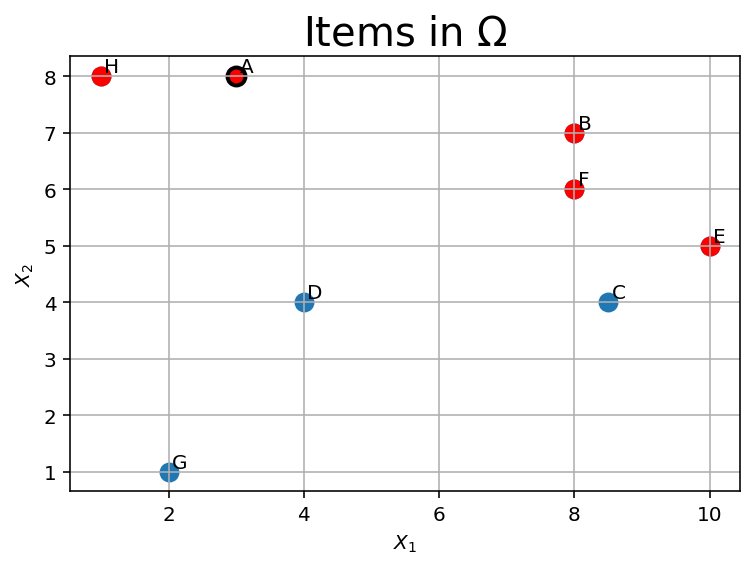

In [17]:
## YOUR SOLUTION
attraction_env.plot_omega()

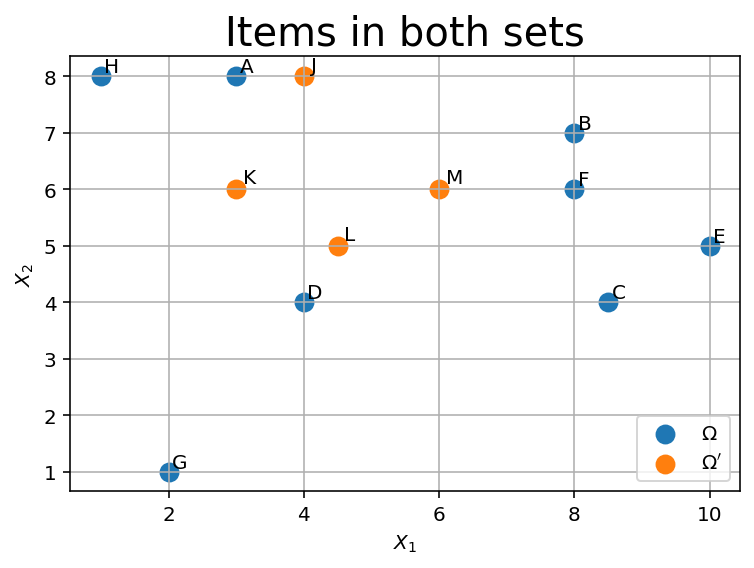

In [18]:
## YOUR SOLUTION
attraction_env.plot_two_sets()

**Which item will you add and why?** (you can use the code to experiment)

In [19]:
def system_utility(df_generate, df_inspect, system_val_column = 'E_s',choice_column = 'chosen'):
  chosen_item = str(df_generate[df_generate[choice_column] == 1]['name'].iloc[0])
  sys_val = df_inspect[df_inspect['name'] == chosen_item][system_val_column].iloc[0]
  return chosen_item, sys_val

max_sys_util, best_item_to_add = 0, 0 
best_item = 0 

df_inspect_tag = attraction_env.inspect_data(items_type="tag")
for item_idx in range(len(attraction_env.omega_tag[0])): 
  attraction_env.add_item(index=item_idx)

  # plotting:
  # attraction_env.plot_omega()
  df_generate = attraction_env.generate_datasets()
  df_inspect = attraction_env.inspect_data(items_type="current")

  cur_chosen_item, cur_sys_util = system_utility(df_generate, df_inspect)
  if(cur_sys_util > max_sys_util):
    max_sys_util, best_item_to_add_idx =  cur_sys_util, item_idx
    best_chosen_item = cur_chosen_item
     
  attraction_env.pop_item()

  # print("the system's utility is: " + str(system_utility(df_generate, df_inspect)))
best_item_to_add_str = str(df_inspect_tag['name'].iloc[best_item_to_add_idx]) 
print("best item to add is: " +best_item_to_add_str+ " which causes item: " +str(best_chosen_item)+  " to be chosen, and gives a system utiliy: " +str(max_sys_util))

print("\nThe row in Omega_tag representing " +best_item_to_add_str+" :\n")
print(df_inspect_tag.iloc[best_item_to_add_idx])

here1
len(data) =  9
observations_per_user =  50
here2
here3
here1
len(data) =  9
observations_per_user =  50
here2
here3
here1
len(data) =  9
observations_per_user =  50
here2
here3
here1
len(data) =  9
observations_per_user =  50
here2
here3
best item to add is: K which causes item: B to be chosen, and gives a system utiliy: 90

The row in Omega_tag representing K :

index                    1
0                      3.0
1                      6.0
user_id                0.0
slate_id               0.0
rantional_user_val    57.0
E_s                      8
name                     K
Name: 1, dtype: object


**Explanation:**

The item with (X1=3, X2=6), when looking specifically on the trade-off between value B to be chosen instead of A previously chosen, we see that this point contributes most to the dominance of B and is not dominated by A.
In fact, all point in Omega_tag are neither dominated or dominate A, so their effect is adding attrcation to B, and as we see, item with (X1=3, X2=6) gives the most.

1.2.2 Add code to generate the final plot, showing recommendations and choice after you have added the additional item.

here1
len(data) =  9
observations_per_user =  50
here2
here3


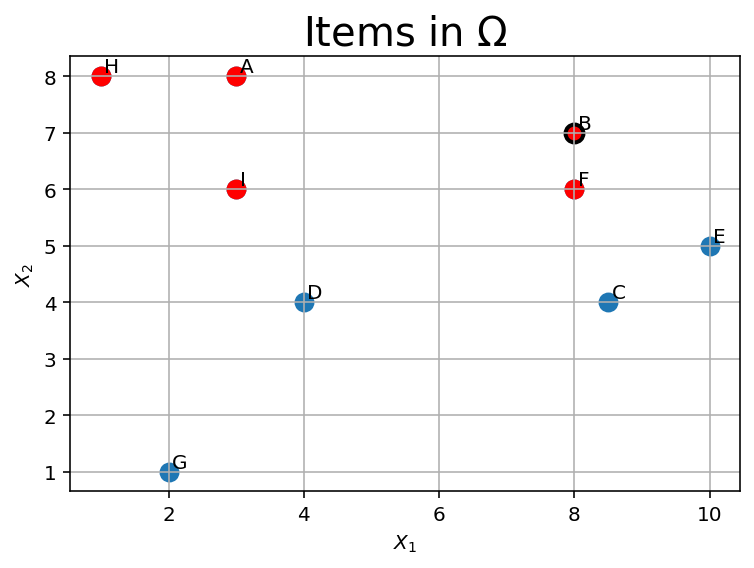

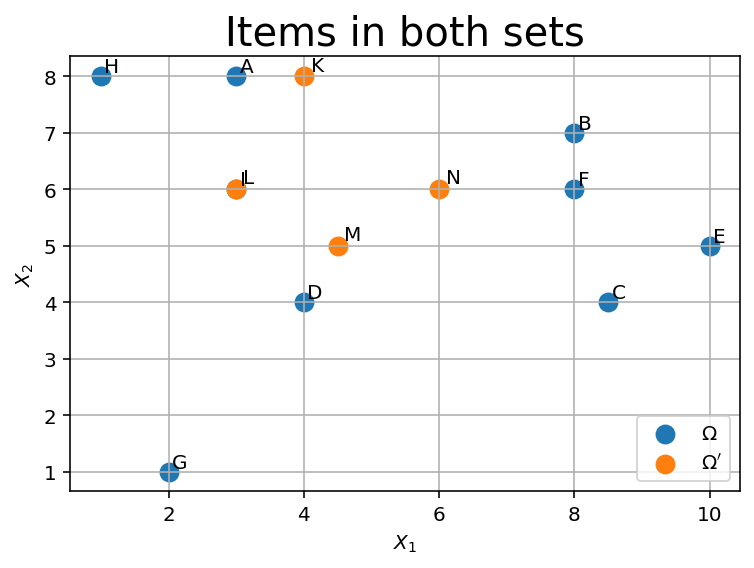

In [20]:
## YOUR SOLUTION
# plotting:
attraction_env.add_item(index=best_item_to_add_idx)
attraction_env.plot_omega()
attraction_env.plot_two_sets()
attraction_env.pop_item()

1.2.3 Calculate welfare and regret for before and after adding the additional item. Print your results.


In [21]:
df = attraction_env.generate_datasets()
# print(df)
attraction_env.add_item(index=best_item_to_add_idx)
df_new = attraction_env.generate_datasets()
# print(df_new)

## YOUR SOLUTION

welfare_before = welfare(df)
welfare_after = welfare(df_new)

print(f'welfare before adding additional item = {welfare_before}\n\
welfare after adding additional item = {welfare_after}')

regret_before = regret(df)
regret_after = regret(df_new)


print(f'regret before adding additional item = {regret_before}\n\
regret after adding additional item = {regret_after}') 


here1
len(data) =  8
observations_per_user =  50
here2
here3
here1
len(data) =  9
observations_per_user =  50
here2
here3
welfare before adding additional item = 75.0
welfare after adding additional item = 71.0
regret before adding additional item = 5.692099788303082
regret after adding additional item = 16.07118598199662


# Task2: your ranker

Here you implement your ranking algorithm class. 

Load Train and test datasets:

In [179]:
## YOUR SOLUTION
from google.colab import drive
drive.mount('/content/drive')
train_data, train_labels = pd.read_pickle('train.pkl') , pd.read_pickle('train_labels.pkl')
test_data, test_labels = pd.read_pickle('test.pkl'), pd.read_pickle('test_labels.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Your Ranker implementation

In [184]:
## YOUR SOLUTION

def tranform_pairwise(X,y):
  #split the data into slates - slate_splitted_X will have #num_slates arrays, each array has an array of items in this slate 
  slate_splitted_X = np.split(train_data[:,1:], np.unique(train_data[:, 0], return_index=True)[1][1:])

  #split the labels into slates - slate_splitted_labels will have #num_slates arrays, each array is a one-hot indicating the chosen item for mthe slate 
  slate_splitted_labels = np.split(train_labels[:, 0], np.unique(train_labels[:, 1], return_index=True)[1][1:])

  X_new, y_new = [], []
  for slate, choice_mask in zip(slate_splitted_X, slate_splitted_labels):
    chosen_item_idx = np.where(choice_mask ==1)[0]
    chosen_item = slate[chosen_item_idx][0]
    
    for j, non_chosen_item in enumerate(slate):
      if j == chosen_item_idx: 
        continue

      # np.random.seed(seed=0)
      a = np.random.choice([-1,1])
      x_bar, y_bar = a*(chosen_item - non_chosen_item), a
      X_new.append(x_bar)
      y_new.append(y_bar)
    
  return np.array(X_new), np.array(y_new)


## YOUR SOLUTION
class MyRanker(svm.LinearSVC):
  def Fit(self, X, y):
    X_new, y_new = tranform_pairwise(X,y)
    
    # fit a lineasr classifier and save its coefficients
    self.coef =  self.fit(X_new, y_new).coef_
    return self
  
  def Predict(self, X):
    slate_splitted_X = np.split(X[:,1:], np.unique(X[:, 0], return_index=True)[1][1:])
    y_pred = None
    # for each slate, calculate the score of the items and return the one with the highest score
    for slate in slate_splitted_X:
      slate_scores = slate @ self.coef.reshape(-1,1)
      chosen_item_idx = np.argmax(slate_scores, axis = 0)
      slate_choice_mask = np.zeros(len(slate))
      slate_choice_mask[chosen_item_idx] = 1
      if y_pred is None:
        y_pred = slate_choice_mask
      else:
        y_pred = np.append(y_pred,slate_choice_mask) 
    return y_pred



Test Your ranker with the example inputs, print accuracy.

In [185]:
from sklearn.metrics import accuracy_score
ranker = MyRanker().Fit(train_data, train_labels)
y_pred = ranker.Predict(test_data)

accuracy = accuracy_score(test_labels, y_pred)
print(f'ranker accuracy = {accuracy:.0%}')

ranker accuracy = 100%
